<a href="https://colab.research.google.com/github/usmanqadeer1/AI-MLProjects/blob/master/Tensorflow_Specialization/Time_series_forecast_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.0


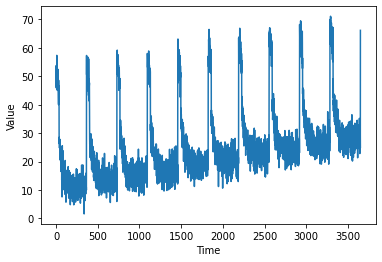

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 2 * np.pi),
                     1 / np.exp(8 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

#Learning rate test

Desired output -- a chart that looks like this:

![Chart showing upward trend and seasonailty](http://www.laurencemoroney.com/wp-content/uploads/2019/07/plot1.png)

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)


In [ ]:

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'), 
    tf.keras.layers.Dense(1)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-4 * 10**(epoch / 20))
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(0.001))
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
94/94 [==============================] - 0s 3ms/step - loss: 408.2348
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 103.3297
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 63.0900
Epoch 4/100
94/94 [==============================] - 0s 3ms/step - loss: 58.3809
Epoch 5/100
94/94 [==============================] - 0s 4ms/step - loss: 52.2508
Epoch 6/100
94/94 [==============================] - 0s 3ms/step - loss: 45.2040
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 39.5242
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 34.5979
Epoch 9/100
94/94 [==============================] - 0s 3ms/step - loss: 30.6333
Epoch 10/100
94/94 [==============================] - 0s 4ms/step - loss: 27.6956
Epoch 11/100
94/94 [==============================] - 0s 4ms/step - loss: 25.8273
Epoch 12/100
94/94 [==============================] - 0s 4ms/step - loss: 24.5360
Epoch 13/100
94/94 [===

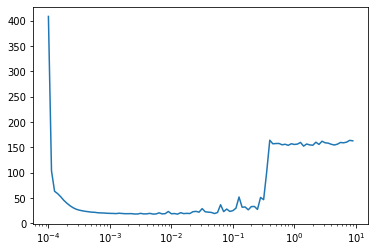

In [ ]:
lrs = 1e-4 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
# plt.axis([1e-3, 1e-5, 0, 300])

In [ ]:
lrs[np.argmin(history.history["loss"])]

0.012589254117941677

# Training

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'relu', input_shape=[window_size]),
    tf.keras.layers.Dense(10, activation = 'relu'), 
    tf.keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer = tf.keras.optimizers.Adam(0.001))
model.fit(dataset,epochs=100)


Epoch 1/100
94/94 [==============================] - 0s 3ms/step - loss: 41.3493
Epoch 2/100
94/94 [==============================] - 0s 3ms/step - loss: 21.9143
Epoch 3/100
94/94 [==============================] - 0s 3ms/step - loss: 20.5329
Epoch 4/100
94/94 [==============================] - 0s 4ms/step - loss: 20.5362
Epoch 5/100
94/94 [==============================] - 0s 3ms/step - loss: 20.1003
Epoch 6/100
94/94 [==============================] - 0s 4ms/step - loss: 20.9587
Epoch 7/100
94/94 [==============================] - 0s 4ms/step - loss: 19.1200
Epoch 8/100
94/94 [==============================] - 0s 4ms/step - loss: 19.1588
Epoch 9/100
94/94 [==============================] - 0s 4ms/step - loss: 18.5704
Epoch 10/100
94/94 [==============================] - 0s 3ms/step - loss: 18.5482
Epoch 11/100
94/94 [==============================] - 0s 4ms/step - loss: 18.9127
Epoch 12/100
94/94 [==============================] - 0s 4ms/step - loss: 18.0314
Epoch 13/100
94/94 [=====

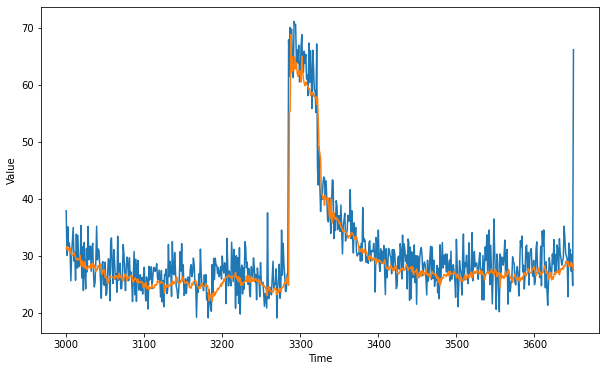

In [ ]:
forecast = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()


2.92271